In [1]:
# import libraries ต่าง ๆ ที่จะใช้
import torch
import os
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # ใช้ในการแบ่งข้อมูล
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from torchmetrics.classification import MulticlassPrecisionRecallCurve
from torch.utils.data import WeightedRandomSampler
import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from optuna.integration.tensorboard import TensorBoardCallback
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

In [2]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/1 cleaned_dataset_MERGED_DRUG(Mogran)_ALLELESEQ.csv", index_col = None)
# assign stratify
df_stratify = pd.DataFrame()
df['ADR'] = df['ADR'].replace({'SJS': 0, 'TEN': 1, 'MPexanthema':2,'MPeruption':3})
df_stratify['ADR'] = df['ADR'].copy()
# drop unnessary columns
df.drop(columns=['No_ADR','ADR','ADR_MPeruption','ADR_MPexanthema','ADR_SJS','ADR_TEN','Cohort ethnicity','Allele','Drug'], inplace=True)

In [3]:
# # To experiment with onehot encoding
# df = pd.concat([df,pd.get_dummies(df['Allele']),pd.get_dummies(df['Drug'])], axis=1)
# df.drop(columns=['Allele','Drug'], inplace=True)
# for x in df.columns:
#     print(x)

In [4]:
# define get_dataset()
def get_dataset(df, BATCHSIZE, outputcol):
    #from torchsampler import ImbalancedDatasetSampler
    df2 = df.copy()
    df_labels = df2[outputcol]
    df2.drop(columns=outputcol, inplace=True)
    
    df_input = df2.iloc[:, 1:]
    print(df_input)
    print(df_labels)
    np_input = df_input.to_numpy()
    np_labels = df_labels.to_numpy()
    np_stratify = df_stratify.to_numpy()

    #train test split
    train_data, test_data, train_labels, test_labels = train_test_split(np_input, np_labels, test_size=0.2, random_state=128, stratify=np_stratify, shuffle = True)
    
    print('train_label data distribution 0/1: {}/{}'.format(
    len(np.where(train_labels == 0)[0]), len(np.where(train_labels == 1)[0])))
    
    print('test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(test_labels == 0)[0]), len(np.where(test_labels == 1)[0])))

    #calculate weight for each class in train_labels
    weight = (1/pd.DataFrame(train_labels).value_counts()).tolist()
    
    #create weight array for train_labels
    sample_weights = np.array([weight[int(t)] for t in train_labels])
    
    #assign weight to Weighted Random Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)
    
    #แปลง numpy เข้า TensorDataSet และ DataLoader
    train_dataset = TensorDataset(torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).float())
    test_dataset = TensorDataset(torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).float())
    train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=test_labels.shape[0])

    #loop ดูภาพรวมของ train_loader
    for i, (data, target) in enumerate(train_loader):
        print("batch index {}, 0/1: {}/{}".format(
            i,
            len(np.where(target.numpy() == 0)[0]),
            len(np.where(target.numpy() == 1)[0])))

    return train_loader, test_loader

In [5]:
# Function to check dataloader classes distribution
def get_dataloader_distribution(*args):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])

        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/3) ,label = "NoADR",color='green',alpha=0.5)
        ax[index].bar(X_axis+(1/3),class_1_count,width=(1/3), label = 'ADR',color='red',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()

        ax[index].set_title(f"{dataloader} Data Distribution")
    fig.show()


       Cohort ethnicity_Caucasian  Cohort ethnicity_Diverse  \
0                               0                         1   
1                               0                         1   
2                               0                         1   
3                               0                         0   
4                               0                         0   
...                           ...                       ...   
13068                           0                         0   
13069                           0                         0   
13070                           0                         0   
13071                           0                         0   
13072                           0                         0   

       Cohort ethnicity_Mongol  0  1  2  3  4  5  6  ...  p2.54.M  p2.54.N  \
0                            0  0  0  0  0  0  0  0  ...        0        0   
1                            0  0  0  0  0  0  0  0  ...        0        0   
2        

c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


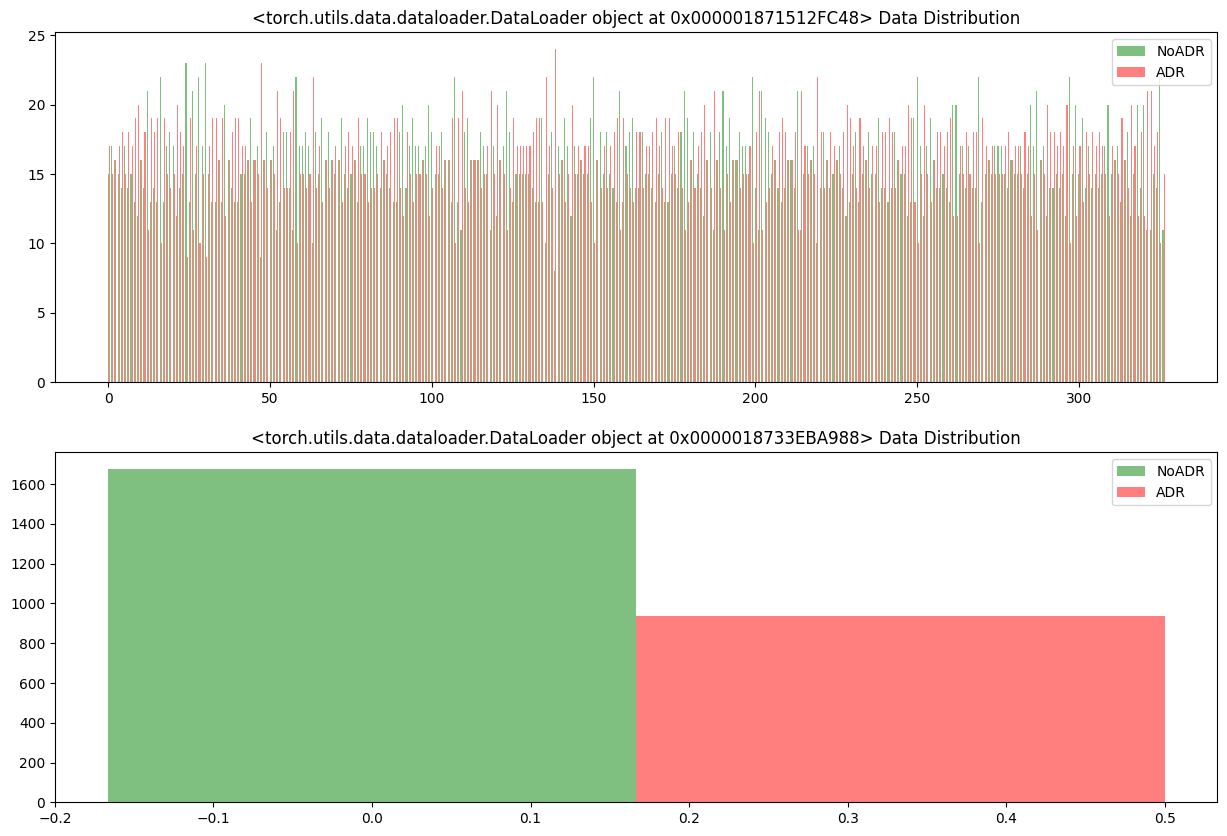

In [6]:
# Define the model hyperparameters
CLASSES = 1
BATCHSIZE = 32 #เดิมใช้ 1024
LEARNING_RATE = 2e-5 #เดิมใช้ 1e-5
#train_loader, test_loader = get_dataset(df,batch_size)
DROPOUT_RATE = 0.2
L2lambda = 0.01
EPOCHS = 1000 #เดิมใช้ 500
DIR = os.getcwd()
dirname = "logs_REALLYFINAL_optimizenode-layer" #แก้ตรงนี้ทุกครั้งเวลาเปลี่ยน hyperparameters ต่าง ๆ จะได้แยกเก็บ study !
train_loader, test_loader = get_dataset(df,BATCHSIZE,'Yes_ADR')
loss_fn = nn.BCELoss() #ไม่ได้แถม sigmoid มาด้วย!!!!!
get_dataloader_distribution(train_loader,test_loader)

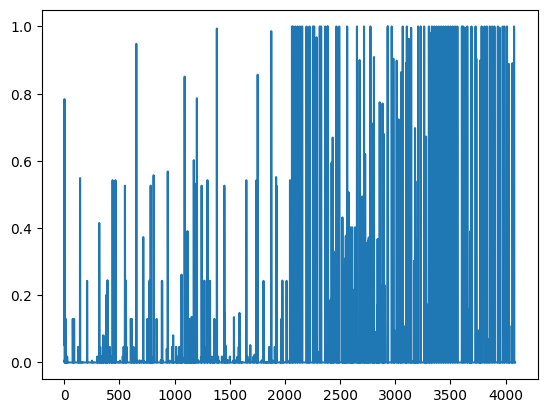

In [7]:
plt.plot(np.mean(train_loader.dataset.tensors[0].numpy(),axis=0))

In [8]:
train_loader.dataset.tensors[0].numpy()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [9]:
# Empty CUDA cache
torch.cuda.empty_cache()

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = device

#N_TRAIN_EXAMPLES = len(train_loader.dataset.tensors[0])
#N_VALID_EXAMPLES = len(test_loader.dataset.tensors[0])

# Tensorboard Integration
writer = SummaryWriter()

def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 6) #อย่าลืมบวก 1 เพราะ append ไปก่อนเข้า loop แล้ว
    layers = []
    in_features = train_loader.dataset.tensors[0].shape[1]
    #layers.append(nn.Linear(in_features, 2048)) # 1024 nodes in the first layer เพื่อบังคับไม่ให้ layer แรกเล็กเกินไป
    #in_features = 2048 #จำนวนที่จะ input เข้าไปยัง hidden layer ที่ 2
    for i in range(n_layers):
        #out_features = trial.suggest_int("n_units_l{}".format(i), 5, 4096) 
        out_features = trial.suggest_int("n_units_l{}".format(i), 256, 2048, 256) 

        layers.append(nn.BatchNorm1d(in_features))
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        #p = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.4) 
        layers.append(nn.Dropout(DROPOUT_RATE)) #DROPOUT_RATE

        in_features = out_features
    #layers.append(nn.Linear(in_features, 2048)) #เพิ่มเพ่อบังคับให้ layer สุดท้าย 2048 ตามผลของ optuna
    #layers.append(nn.ReLU()) 
    layers.append(nn.Linear(out_features, CLASSES)) #รับ 2048 แล้วออกมาเป็น 1 output ผ่าน sigmoid
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)



def objective(trial):
    # Generate the model.
    model = define_model(trial).to(DEVICE)
    
    with torch.no_grad():
        dataiter = iter(train_loader)
        input,output = next(dataiter)
        input = input.to(DEVICE)
        writer.add_graph(model, input) #เพิ่ม graph ของ model ลง tensorboard



    print(model)
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"]) #ให้เลือกแค่ Adam อย่างเดียว ไม่ได้ลบไว้เพราะเผื่อจะใส่ SGD ให้ optuna ลองเลือก
    #lr = trial.suggest_float("lr", 1e-6, 1e-5, log=True)
    lr = LEARNING_RATE #ใช้ lr ที่ define ไว้ (ไม่ต้อง optimize)
    #L2lambda = trial.suggest_float("L2lambda", 1e-3, 1e-2, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=L2lambda) #เพิ่ม weight decay เพื่อให้ model ไม่ overfit
    run_name = "trial-%d" % trial.number
    run_dir = os.path.join(dirname, run_name) # This is the dir used in tensorboard_callback of optuna
    
    # Training of the model.
    for epoch in range(EPOCHS):
        running_loss = []
        running_train_acc = []
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # # Limiting training data for faster epochs.
            # if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #     break


            data = data.float().to(device)
            target = target.float().to(device)

            optimizer.zero_grad()
            output = model(data)
            output = output.flatten()
            
            loss = loss_fn(output,target)
            loss.backward()
            optimizer.step()
    
            running_loss.append(loss.item()) 

            with torch.no_grad():
                target = target.flatten()
                output = torch.round(output)
                correct = (output == target).sum().item()
                train_acc = correct/len(target)
                train_acc = round(train_acc, 8)
                running_train_acc.append(train_acc)
        train_acc = np.mean(running_train_acc)
        train_loss = np.mean(running_loss)
        
        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # # Limiting validation data.
                # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #     break
                data = data.float().to(device)
                target = target.float().to(device)               
                output = model(data)
                output = output.flatten()
                #data = data.flatten()
                test_loss = loss_fn(output, target)
                output = torch.round(output)
                correct = (output == target).sum().item()
                
                # # Get the index of the max log-probability.
                # pred = output.argmax(dim=1, keepdim=True)
                # correct += pred.eq(target.view_as(pred)).sum().item()
        #accuracy = correct/len(valid_loader.dataset)
            test_acc = correct / len(test_loader.dataset) #min(len(test_loader.dataset),N_VALID_EXAMPLES)
            

            
            output = output.cpu().detach().numpy()
            target = target.cpu().detach().numpy()
        
            test_loss = test_loss.cpu().detach().numpy()
   


            test_precision = precision_score(output, target, zero_division=0)
            test_f1_score = f1_score(output, target, zero_division=0)
            test_recall_score = recall_score(output, target, zero_division=0)

        print(f"train accuracy: {train_acc}, test accuracy:{test_acc} train loss:{round(train_loss,8)}, test loss:{round(test_loss.item(),8)}, test precision: {test_precision},test recall: {test_recall_score},test f1: {test_f1_score}")
        with tf.summary.create_file_writer(f"{run_dir}_train").as_default():
            tf.summary.scalar("loss", train_loss, step=epoch)
            tf.summary.scalar("acc", train_acc, step=epoch)
        with tf.summary.create_file_writer(f"{run_dir}_test").as_default():    
            tf.summary.scalar("loss", test_loss, step=epoch) 
            tf.summary.scalar("acc", test_acc, step=epoch)
            tf.summary.scalar("precision", test_precision, step=epoch)
            tf.summary.scalar("f1_score", test_f1_score, step=epoch)
            tf.summary.scalar("recall_score", test_recall_score, step=epoch)
            trial.report(test_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    torch.save(model.state_dict(),f"../4 - Training & Testing/{dirname}/{'trial-%d_model.pt' % trial.number}")
    return train_loss

if __name__ == "__main__":
    tensorboard_callback = TensorBoardCallback(dirname = dirname, metric_name="target")
    pruner = optuna.pruners.HyperbandPruner(min_resource=1, max_resource=EPOCHS, reduction_factor=3)
    study = optuna.create_study(study_name = dirname, directions=["minimize"],sampler=TPESampler(),storage='sqlite:///optuna.sqlite3',pruner=pruner, load_if_exists=True)
    study.optimize(objective, n_trials=1000, timeout=None)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:152: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
[I 2023-04-09 10:20:42,280] A new study created in RDB with name: logs_REALLYFINAL_optimizenode-layer


Sequential(
  (0): BatchNorm1d(4088, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=4088, out_features=1536, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=1536, out_features=1024, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=1536, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Linear(in_features=1536, out_features=2048, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.2, inplace=False)
  (16): Linear(in_features=2048, out_features=1, bias=True)
  (17): Sigmoid()
)
train accuracy: 0.6398494471865444, test accuracy:0.6837476099426386 train loss:0.63133943, te

[I 2023-04-09 11:35:03,461] Trial 0 finished with value: 0.5776542334928425 and parameters: {'n_layers': 4, 'n_units_l0': 1536, 'n_units_l1': 1024, 'n_units_l2': 1536, 'n_units_l3': 2048, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5776542334928425.


train accuracy: 0.69441749, test accuracy:0.710133843212237 train loss:0.57765423, test loss:0.60116899, test precision: 0.5292864749733759,test recall: 0.6113161131611317,test f1: 0.5673515981735159
Sequential(
  (0): BatchNorm1d(4088, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=4088, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=512, out_features=512, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=512, out_features=1, bias=True)
  (9): Sigmoid()
)
train accuracy: 0.6400920371559633, test accuracy:0.6933078393881453 train loss:0.63475911, test loss:0.60628712, test precision: 0.6421725239616614,test recall: 0.5640785781103835,test f1: 0.6005976095617529
train accuracy: 0.6667769348318043, test accuracy:0.6883365200764818 train loss:0.61082609, test loss:

[W 2023-04-09 11:38:56,486] Trial 1 failed with parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 512, 'optimizer': 'Adam'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\harit\AppData\Local\Temp\ipykernel_50608\434134376.py", line 68, in objective
    for batch_idx, (data, target) in enumerate(train_loader):
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\utils\data\dataloader.py", line 624, in __next__
    with torch.autograd.profiler.record_function(self._profile_name):
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\autograd\profiler.py", line 488, in __enter__
    self.handle = torch.ops.profiler._record_function_enter(self.name, self.args)
  File "c:\Users\harit\AppData\Loca

KeyboardInterrupt: 

In [10]:
study.best_trial

FrozenTrial(number=16, state=TrialState.COMPLETE, values=[0.571486933664842], datetime_start=datetime.datetime(2023, 4, 6, 16, 59, 0, 352266), datetime_complete=datetime.datetime(2023, 4, 6, 17, 1, 9, 260005), params={'n_layers': 8, 'n_units_l0': 1175, 'n_units_l1': 3702, 'n_units_l2': 657, 'n_units_l3': 2140, 'n_units_l4': 2679, 'n_units_l5': 3443, 'n_units_l6': 1510, 'n_units_l7': 1746, 'optimizer': 'Adam'}, user_attrs={}, system_attrs={'completed_rung_0': 0.602394163608551, 'completed_rung_1': 0.608176589012146, 'completed_rung_2': 0.6243059635162354}, intermediate_values={0: 0.696273922920227, 1: 0.6939924359321594, 2: 0.6883816719055176, 3: 0.6776053309440613, 4: 0.6536971926689148, 5: 0.6797589063644409, 6: 0.6296790838241577, 7: 0.6156091690063477, 8: 0.5982238054275513, 9: 0.602394163608551, 10: 0.6207632422447205, 11: 0.6043296456336975, 12: 0.5907427072525024, 13: 0.6367999315261841, 14: 0.5899409055709839, 15: 0.5957279801368713, 16: 0.608992874622345, 17: 0.5987521409988403

In [8]:
test_model = nn.Sequential(
    nn.Linear(train_loader.dataset.tensors[0].shape[1], 637),
    nn.ReLU(),
    nn.Linear(637, 3513),
    nn.ReLU(),
    nn.Linear(3513,1015),
    nn.ReLU(),
    nn.Linear(1015,3136),
    nn.ReLU(),
    nn.Linear(3136, 328),
    nn.ReLU(),
    nn.Linear(328, 1),
    nn.Sigmoid()
)
test_model = test_model
test_model.load_state_dict(torch.load('../4 - Training & Testing/logs_test_final_3_MORGAN/trial-0_model.pt'))

correct = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # # Limiting validation data.
        # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
        #     break
        data = data.float()
        target = target.float()            
        output = test_model(data)
        output = output.flatten()
        #data = data.flatten()
        #test_loss = loss_fn(output, target)
        output = torch.round(output)
        correct = (output == target).sum().item()
        
        # # Get the index of the max log-probability.
        # pred = output.argmax(dim=1, keepdim=True)
        # correct += pred.eq(target.view_as(pred)).sum().item()
#accuracy = correct/len(valid_loader.dataset)
    test_acc = correct / len(test_loader.dataset) #min(len(test_loader.dataset),N_VALID_EXAMPLES)

test_acc


1.0

In [72]:
target.dytyp

torch.float32

In [45]:
pd.DataFrame(data.detach().cpu().numpy()).to_csv('check0.csv',index=False)

In [37]:
test_model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=4089, out_features=637, bias=True)
  (1): ReLU()
  (2): Linear(in_features=637, out_features=3513, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3513, out_features=1015, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1015, out_features=3136, bias=True)
  (7): ReLU()
  (8): Linear(in_features=3136, out_features=328, bias=True)
  (9): ReLU()
  (10): Linear(in_features=328, out_features=1, bias=True)
  (11): Sigmoid()
)>

In [28]:
test_loader.dataset.tensors[0].shape

torch.Size([2615, 4089])

# ของเก่า

In [ ]:
writer = SummaryWriter()
trend = ""

#trainAcc,testAcc,trainLoss = TrainTest()


allepoch_train_loss = []
allepoch_test_loss = []
allepoch_test_acc = []
allepoch_train_acc = []


count = 0

for epoch_i in range(epochs):
    #print(f"Epochs: {epoch_i+1}")
    #print("----")
    #batch_no = 0
    running_loss = [] #clear running loss ทุกครั้ง
    running_train_acc = []
    for batch in train_loader:

        model.train().to(device)

        #batch_no += train_loader.batch_size

        train_data, train_label = batch
        train_data = train_data.float().to(device)
        train_label = train_label.float().to(device)
        #train_label = train_label.reshape((len(train_label)),1)

        optimizer.zero_grad()
        outputs = model(train_data)
        outputs = outputs.flatten()
        loss = loss_fn(outputs, train_label)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item()) 
        
        #if batch_no % 100 == 0:
            #print(f"Loss: {loss.item():>e} Batch: {batch_no:>5d}/{train_loader.batch_size*len(train_loader):>5d}")


        #train accuracy
        with torch.no_grad():
            #outputs = model(train_data)
            #outputs_sigmoid = torch.sigmoid(outputs)
            outputs = torch.round(outputs)
            #_, predicted = torch.max(outputs, 1)
            #train_label = torch.max(train_label, 1)
            outputs = outputs.flatten()
            train_label = train_label.flatten()
            correct = (outputs == train_label).sum().item()
            train_accuracy = correct/len(train_label)
            train_accuracy = round(train_accuracy, 8)
            running_train_acc.append(train_accuracy)
        train_acc = np.mean(running_train_acc)
        allepoch_train_acc.append(train_acc)
        
    model.eval()
    #test accuracy
    testacc = []
    for batch in test_loader:
        test_data, test_label = batch
        test_label = test_label.float().to(device)
        test_data = test_data.float().to(device)
        with torch.no_grad():
            outputs = model(test_data).to(device)
            
            #outputs_sigmoid = torch.sigmoid(outputs)
            
            #test_label = torch.max(test_label, 1)\
            outputs = outputs.flatten()
            test_label = test_label.flatten()
            #_, predicted = torch.max(outputs, 1)
            test_loss = loss_fn(outputs, test_label)

            outputs = torch.round(outputs)
            correct = (outputs == test_label).sum().item()
            test_loss = round(test_loss.item(),8)
            test_accuracy = correct/len(test_label)
            test_accuracy = round(test_accuracy,8)
            allepoch_test_acc.append(test_accuracy)
            allepoch_test_loss.append(test_loss)
    
    train_loss = round(np.mean(running_loss),8)
    allepoch_train_loss.append(train_loss)

    writer.add_scalars('Accuracy', {
        'train accuracy':train_accuracy*100,
        'test accuracy': test_accuracy*100
        }, epoch_i+1)
    

    writer.add_scalars('Loss', {
        'train loss':np.mean(running_loss),
        'test loss': test_loss
        }, epoch_i+1)


    print(f"{epoch_i} {trend}, Train Loss: {train_loss}, Test Loss: {test_loss}, Train_Accuracy: {train_accuracy*100}, Test_Accuracy: {test_accuracy*100}")

    if epoch_i > 3:
        if allepoch_train_loss[epoch_i-2] - allepoch_train_loss[epoch_i-1] <= 0:
            count += 1
            trend = "Down"
        else:
            trend = "UP!!"
            count = 0

        if count == 20:
            print(f"Early Stopped, loss not increasing for {count} times")
            break
    else:
        trend = "Not yet >3 epoch"


0 , Train Loss: 50.4695717, Test Loss: 64.59366608, Train_Accuracy: 51.785714000000006, Test_Accuracy: 35.406333000000004
1 Not yet >3 epoch, Train Loss: 49.90880882, Test Loss: 64.59366608, Train_Accuracy: 53.571429, Test_Accuracy: 35.406333000000004
2 Not yet >3 epoch, Train Loss: 50.6832535, Test Loss: 64.59366608, Train_Accuracy: 51.785714000000006, Test_Accuracy: 35.406333000000004
3 Not yet >3 epoch, Train Loss: 50.43554008, Test Loss: 64.59366608, Train_Accuracy: 45.535714, Test_Accuracy: 35.406333000000004
4 Not yet >3 epoch, Train Loss: 50.76627834, Test Loss: 64.59366608, Train_Accuracy: 47.321428999999995, Test_Accuracy: 35.406333000000004
5 UP!!, Train Loss: 50.07077529, Test Loss: 64.59366608, Train_Accuracy: 59.821429, Test_Accuracy: 35.406333000000004
6 Down, Train Loss: 49.43243687, Test Loss: 64.59366608, Train_Accuracy: 53.571429, Test_Accuracy: 35.406333000000004
7 UP!!, Train Loss: 50.49814899, Test Loss: 64.59366608, Train_Accuracy: 48.214286, Test_Accuracy: 35.406

KeyboardInterrupt: 

In [ ]:
to_plot.index.tolist()

[(0.0,), (1.0,)]

In [ ]:
to_plot.index.values.tolist()

[(0.0,), (1.0,)]

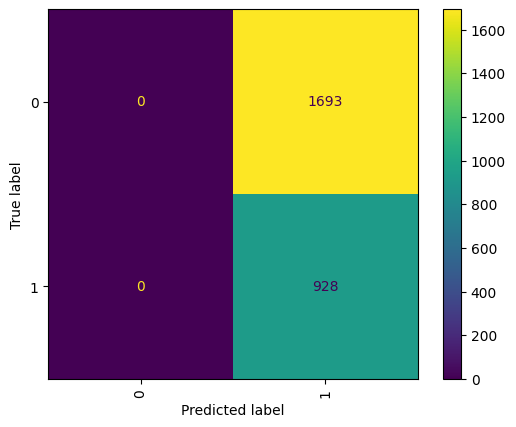

In [ ]:
with torch.no_grad():
    data = test_loader.dataset.tensors[0].to(device)
    predicted = model(data).to(device)
    predicted = predicted.cpu()
    predicted = predicted.flatten()
    target = test_loader.dataset.tensors[1].flatten()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sn

#classes = true_labels.keys()
#classes = list(df_labels.columns)
cf_matrix = confusion_matrix(target, predicted)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
#plt.figure(figsize = (12,7))
#sn.heatmap(df_cm, annot=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(xticks_rotation=90)
#disp.figure_.savefig(f'../4 - Training & Testing/models/model_{numberofmodel}_cf.png')

In [ ]:
print(f'Precision: {precision_score(target, predicted)}')
print(f'Accuracy: {accuracy_score(target, predicted)}')
print(f'f1_score: {f1_score(target, predicted)}')
print(f'recall_score: {recall_score(target, predicted)}')

Precision: 0.3540633346051126
Accuracy: 0.3540633346051126
f1_score: 0.5229642152719076
recall_score: 1.0


In [ ]:
print(f'Precision: {precision_score(target, predicted)}')
print(f'Accuracy: {accuracy_score(target, predicted)}')
print(f'f1_score: {f1_score(target, predicted)}')
print(f'recall_score: {recall_score(target, predicted)}')

Precision: 0.3540633346051126
Accuracy: 0.3540633346051126
f1_score: 0.5229642152719076
recall_score: 1.0


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


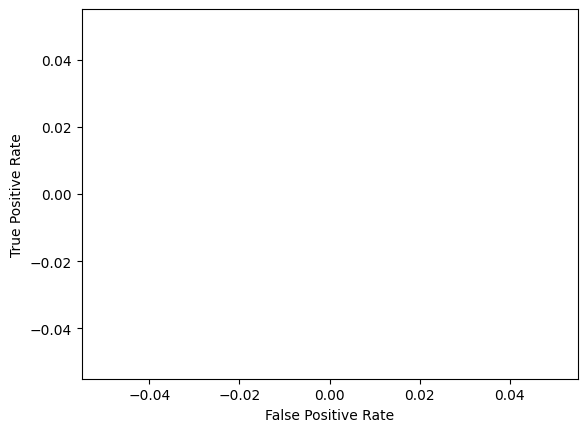

In [ ]:
from sklearn.metrics import roc_curve

nn_fpr, nn_tpr, nn_thresholds = roc_curve(predicted, target)
plt.plot(nn_fpr,nn_tpr,marker='.')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate' )
plt.show()

In [ ]:
study.best_trial

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.6459366653948875], datetime_start=datetime.datetime(2023, 3, 30, 1, 16, 35, 756185), datetime_complete=datetime.datetime(2023, 3, 30, 1, 16, 58, 526080), params={'lr': 0.0041130297587676085, 'n_layers': 8, 'n_units_l0': 1456, 'n_units_l1': 1579, 'n_units_l2': 1542, 'n_units_l3': 1024, 'n_units_l4': 936, 'n_units_l5': 1804, 'n_units_l6': 351, 'n_units_l7': 35, 'optimizer': 'Adam'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.6459366653948875, 1: 0.6459366653948875, 2: 0.6459366653948875, 3: 0.6459366653948875, 4: 0.6459366653948875, 5: 0.6459366653948875, 6: 0.6459366653948875, 7: 0.6459366653948875, 8: 0.6459366653948875, 9: 0.6459366653948875}, distributions={'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'n_layers': IntDistribution(high=10, log=False, low=3, step=1), 'n_units_l0': IntDistribution(high=2048, log=False, low=32, step=1), 'n_units_l1': IntDistribution(high=2048, log=False, low=32

In [ ]:
detailed_objective(study.best_trial)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [ ]:
test_tensor = torch.zeros(len(predicted),10)
test_tensor
count = 0
for x in predicted:
    test_tensor[count][x.item()] = 1
    count += 1
    print(test_tensor)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...

In [ ]:
test_label

torch.return_types.max(
values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
indices=tensor([9, 9, 4,  ..., 9, 8, 9]))

# save model

In [ ]:
# Model Saver
from datetime import datetime
numberofmodel = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [ ]:
#calculate accuracy, precision, recall for each index by matching the value of test_tensor (prediction) and test_label (ground truth)
predicted_dict = {}
for x in range(predicted.shape[0]):
    if torch.argmax(test_tensor[0]).item() in predicted_dict.keys():
        predicted_dict[torch.argmax(test_tensor[0]).item()] += 1
    else:
        predicted_dict[torch.argmax(test_tensor[0]).item()] = 1

label_dict = {}
for x in test_loader.dataset:
    if torch.argmax(x[1]).item() in label_dict.keys():
        label_dict[torch.argmax(x[1]).item()] += 1
    else:
        label_dict[torch.argmax(x[1]).item()] = 1
label_dict = dict(sorted(label_dict.items(), key=lambda item: item[0]))

In [ ]:
true_labels = {'No_ADR': 0,
 'ADR_AIU': 1,
 'ADR_Agranulocytosis': 2,
 'ADR_FDE': 3,
 'ADR_Juandice': 4,
 'ADR_MPeruption': 5,
 'ADR_MPexanthema': 6,
 'ADR_SJSI': 7,
 'ADR_SJSII': 8,
 'ADR_TEN': 9}

 #switch true_labels keys an values
true_labels = {v: k for k, v in true_labels.items()}
true_labels

{0: 'No_ADR',
 1: 'ADR_AIU',
 2: 'ADR_Agranulocytosis',
 3: 'ADR_FDE',
 4: 'ADR_Juandice',
 5: 'ADR_MPeruption',
 6: 'ADR_MPexanthema',
 7: 'ADR_SJSI',
 8: 'ADR_SJSII',
 9: 'ADR_TEN'}

In [ ]:
list(df_labels.columns)

['ADR_AIU',
 'ADR_Agranulocytosis',
 'ADR_FDE',
 'ADR_Juandice',
 'ADR_MPeruption',
 'ADR_MPexanthema',
 'ADR_SJSI',
 'ADR_SJSII',
 'ADR_TEN',
 'No_ADR']

In [ ]:
predicted_dict

{9: 2621}

In [ ]:
label_dict

{2: 1, 4: 103, 5: 133, 6: 350, 7: 64, 8: 277, 9: 1693}

In [ ]:
#remove the keys in true_labels that are not the keys in label_dict
true_labels = {k: v for k, v in true_labels.items() if k in label_dict.keys()}
true_labels

{2: 'ADR_Agranulocytosis',
 4: 'ADR_Juandice',
 5: 'ADR_MPeruption',
 6: 'ADR_MPexanthema',
 7: 'ADR_SJSI',
 8: 'ADR_SJSII',
 9: 'ADR_TEN'}

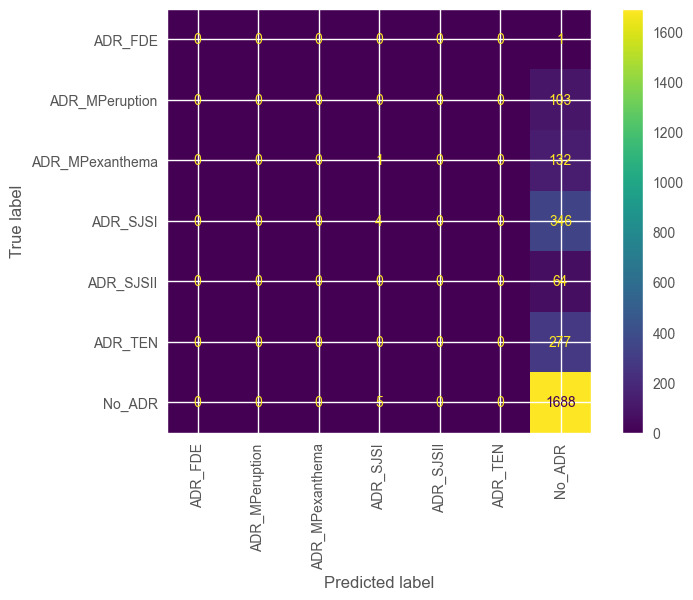

In [ ]:
classes = list(df_labels.columns)

#remove the value in list(df_labels.columns) that got the sum of 0 in df_labels.sum(0)
for x in list(df_labels.columns):
    if df_labels[x].sum(0) == 0:
        classes.remove(x)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

#classes = true_labels.keys()
#classes = list(df_labels.columns)
cf_matrix = confusion_matrix(test_label[1], predicted)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
#plt.figure(figsize = (12,7))
#sn.heatmap(df_cm, annot=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=classes)
disp.plot(xticks_rotation=90)
disp.figure_.savefig(f'../4 - Training & Testing/models/model_{numberofmodel}_cf.png')

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(test_label[1], predicted, target_names=classes)
print(cr)

                 precision    recall  f1-score   support

        ADR_FDE       0.00      0.00      0.00         1
 ADR_MPeruption       0.00      0.00      0.00       103
ADR_MPexanthema       0.00      0.00      0.00       133
       ADR_SJSI       0.40      0.01      0.02       350
      ADR_SJSII       0.00      0.00      0.00        64
        ADR_TEN       0.00      0.00      0.00       277
         No_ADR       0.65      1.00      0.78      1693

       accuracy                           0.65      2621
      macro avg       0.15      0.14      0.12      2621
   weighted avg       0.47      0.65      0.51      2621



c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

NameError: name 'allepoch_train_acc' is not defined

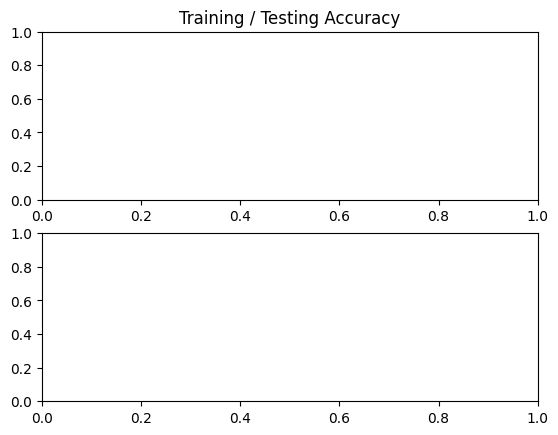

In [11]:
fig, ax = plt.subplots(2,1)
#plt.style.use('ggplot')

ax[0].set_title("Training / Testing Accuracy")
ax[0].plot(allepoch_train_acc, 'red',label='Train',marker='o')
ax[0].plot(allepoch_test_acc,'blue',label='Test',marker='o')
ax[0].xaxis.set(ticks=range(0,len(allepoch_train_acc),1))
ax[0].set_ylabel("Accuracy")
ax[0].legend()
#ax[0].text(4,1,f"Model: {numberofmodel}")


ax[1].set_title("Training loss")
ax[1].set_xlabel("Epochs")
ax[1].plot(allepoch_train_loss,label = 'loss',color='green')
ax[1].plot(allepoch_train_loss,label = 'loss',color='green')
ax[1].xaxis.set(ticks=range(0,len(allepoch_train_acc),1))
ax[1].set_ylabel("Loss")
ax[1].legend()
#plt.show()

plt.tight_layout()#h_pad = 3, w_pad=3)
plt.savefig(f"../4 - Training & Testing/models/model_{numberofmodel}.png")